In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline
from scipy.interpolate import UnivariateSpline

In [2]:
init_dens = pd.read_excel('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/GISP2/Summit_Density_2007.xlsx', skiprows=5, usecols=[1,2])
late_dens = pd.read_csv('/Users/quinnmackay/Documents/GitHub/BICC/Data Storage/GISP2/alley_gisp2_stratigraphy.tab', sep='\t', skiprows=27)

print(late_dens)
init_dens.dropna(inplace=True, subset=['Density (g/cm3)'])

late_dens = late_dens[['Depth ref [m] (Calculated from conductivity)', 'Density [g/cm**3] (Pycnometer (Micromeritics))']]
late_dens.dropna(inplace=True, subset=['Density [g/cm**3] (Pycnometer (Micromeritics))'])
late_dens.dropna(inplace=True, subset=['Depth ref [m] (Calculated from conductivity)'])
late_dens.isna().sum()

      Age [ka BP]  Depth ref [m] (Calculated from conductivity)  \
0           0.247                                         94.05   
1           0.248                                         94.24   
2           0.249                                         94.50   
3           0.250                                         94.75   
4           0.251                                         95.06   
...           ...                                           ...   
1015        1.262                                        333.54   
1016        1.263                                        333.66   
1017        1.264                                        333.94   
1018        1.265                                           NaN   
1019        1.266                                           NaN   

      Depth ref [m] (Visual stratigraphy)  \
0                                     NaN   
1                                   94.28   
2                                   94.65   
3              

Depth ref [m] (Calculated from conductivity)      0
Density [g/cm**3] (Pycnometer (Micromeritics))    0
dtype: int64

In [3]:
dupes = init_dens['Mid-Level Depth (m)'].duplicated()

#drop duplicates, keeping the first occurrence
init_dens = init_dens.drop_duplicates(subset=['Mid-Level Depth (m)'], keep='first')

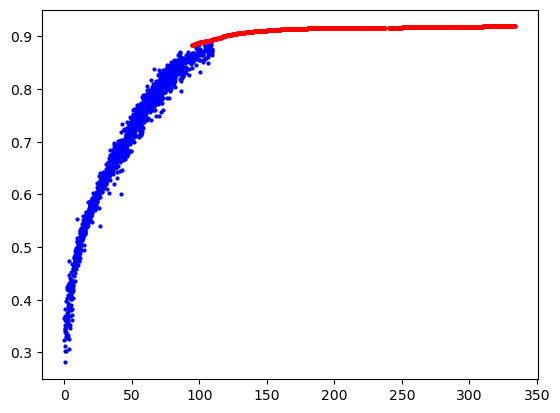

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import make_interp_spline

# --- Sort by depth first ---
init_dens_sorted = init_dens.sort_values(by='Mid-Level Depth (m)')
late_dens_sorted = late_dens.sort_values(by='Depth ref [m] (Calculated from conductivity)')

# --- Scatter plots (sorted data, same look) ---
plt.scatter(init_dens_sorted['Mid-Level Depth (m)'], 
            init_dens_sorted['Density (g/cm3)'], 
            s=4, label='Initial', color='blue')

plt.scatter(late_dens_sorted['Depth ref [m] (Calculated from conductivity)'], 
            late_dens_sorted['Density [g/cm**3] (Pycnometer (Micromeritics))'], 
            s=4, label='Late', color='red')


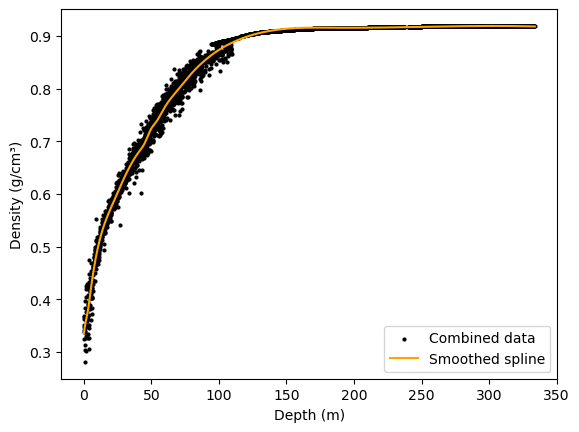

In [5]:
# --- Combine datasets ---
combined = pd.DataFrame({
    "Depth (m)": pd.concat([
        init_dens['Mid-Level Depth (m)'],
        late_dens['Depth ref [m] (Calculated from conductivity)']
    ]),
    "Density (g/cm³)": pd.concat([
        init_dens['Density (g/cm3)'],
        late_dens['Density [g/cm**3] (Pycnometer (Micromeritics))']
    ])
})

# --- Sort by depth ---
combined = combined.sort_values(by="Depth (m)")

# --- Scatter plot ---
plt.scatter(combined['Depth (m)'], combined['Density (g/cm³)'],
            s=4, color='black', label='Combined data')

# --- Smoothing spline ---
x = combined['Depth (m)'].to_numpy()
y = combined['Density (g/cm³)'].to_numpy()

# smoothing factor 's' controls how closely it follows points
spline = UnivariateSpline(x, y, s=0.395)  # try s=10, 50, 200 depending on smoothness

x_smooth = np.linspace(x.min(), x.max(), 500)
y_smooth = spline(x_smooth)

# --- Plot spline ---
plt.plot(x_smooth, y_smooth, color='orange', lw=1.5, label='Smoothed spline')

plt.xlabel("Depth (m)")
plt.ylabel("Density (g/cm³)")
plt.legend()
plt.show()

In [17]:
export_density = pd.DataFrame({
    "depth": x_smooth,
    "rel_dens": y_smooth/0.917,
    'comment': np.nan
})

export_density.loc[export_density['rel_dens'] > 1, 'rel_dens'] = 1

export_density_extend = pd.DataFrame({
    "depth": np.linspace(export_density['depth'].max(), 3050, 500),
    "rel_dens": 1,
    'comment': np.nan
})

pd.concat([export_density, export_density_extend], ignore_index=True).to_csv('/Users/quinnmackay/Desktop/temp/density.txt', sep='\t', index=False)
